In [1]:
from tqdm import tqdm
import json
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import pytorch_lightning as pl
import os
import argparse

/root/miniconda3/envs/py36_LM/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ..

/home/UNILM/summary-QA


In [3]:
from QA_longformer import QA, QA_F1, EM

In [4]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#parser = argparse.ArgumentParser()
#parser.add_argument('--learning_rate', default=5e-5, type=float)
#args = parser.parse_args()
args='a'
QA_model = QA(args)

Some weights of the model checkpoint at markussagen/xlm-roberta-longformer-base-4096 were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.encoder.layer.0.attention.self.query_global.weight', 'roberta.encoder.layer.0.attention.self.query_global.bias', 'roberta.encoder.layer.0.attention.self.key_global.weight', 'roberta.encoder.layer.0.attention.self.key_global.bias', 'roberta.encoder.layer.0.attention.self.value_global.weight', 'roberta.encoder.layer.0.attention.self.value_global.bias', 'roberta.encoder.layer.1.attention.self.query_global.weight', 'roberta.encoder.layer.1.attention.self.query_global.bias', 'roberta.encoder.layer.1.attention.self.key_global.weight', 'roberta.encoder.layer.1.attention.self.key_global.bias', 'roberta.encoder.layer.1.attention.self.value_global.weight', 'roberta.encoder.l

In [14]:
#QA_model.load_state_dict(torch.load('./QA/Longformer_b16_lr5e-5/lightning_logs/version_1/checkpoints/last.ckpt')['state_dict'])
# QA_model.load_state_dict(torch.load('./QA/Longformer_1cycle/lightning_logs/version_2/checkpoints/checkpoints_epoch=19.ckpt')['state_dict'])
QA_model.load_state_dict(torch.load('./QA/Longformer_1cycle/lightning_logs/version_3/checkpoints/checkpoints_epoch=11.ckpt')['state_dict'])

<All keys matched successfully>

In [15]:
tokenizer = AutoTokenizer.from_pretrained('markussagen/xlm-roberta-longformer-base-4096', max_length = 4096, padding ='max_length', truncation=True)

In [16]:
# path = '../../UNILM_/data/KLUE/klue_benchmark/klue-mrc-v1.1/klue-mrc-v1.1_dev.json'
path = '1cycle_2/QA_convert2048.json'
#path ='./klue-mrc-v1.1_train_pre.json'
with open(path, 'r') as fr:
    QA_json = json.load(fr)
print('num_data:',len(QA_json))

num_data: 13543


In [17]:
val_ratio = 0.95
train_len = int(len(QA_json)*val_ratio)
QA_train = QA_json[:train_len]
QA_valid = QA_json[train_len:]

In [18]:
s_list=[]
e_list=[]

In [19]:
idx =16
for idx in range(0,40):#1903,len(jdata['data'])):
    #print(idx)
    elem = QA_valid[idx]
    context = elem['context']
    que = elem['question']
    
    ans = context[elem['start']:elem['end']]
    
    print('question:',que)
    print('answer:',ans)

    inputs = tokenizer(context, que, return_tensors='pt',
                       truncation=True,
                       max_length=1024,
                       padding='max_length',
                       add_special_tokens=True)
    QA_model.model.eval()
    with torch.no_grad():
        result = QA_model.model(**inputs)
        start_idx = result.start_logits.argmax()
        end_idx = result.end_logits.argmax()
        s_list.append(start_idx)
        e_list.append(end_idx)
        print(start_idx.item(), end_idx.item())
        predict_answer_tokens=inputs.input_ids[0,start_idx:end_idx+1]
        print('predict:',tokenizer.decode(predict_answer_tokens))
        print('------------')

question: 간 조직에 실시한 blot 기법은?
answer: Western blot
153 154
predict: Western blot
------------
question: LPS에 의해서 유발된 손상은 무엇인가?
answer: 간세포손상
268 785
predict: NF-\( \kappa \)B p\(65\)의 발현에서는 대조군에 비해 GR\( 0 \)F\( 0 \) 투여군, GR\( 6 \)F\( 4 \) 투여군 모두 유의성 있는 감소를 보이지 않았다. 이로 보아 천마의 항염증의 기전이 전사인자 AP-\( 1 \) 의 발현에 관여하는 것으로 생각된다.</p><p>COX-\(2 \) 와 iNOS 에서는 GR\( 0 \)F\( 0 \) 투여군 및 GR\( 6 \)F\( 4 \) 투여군이 대조군에 비하여 적게 발현되었다. 특히 GR\( 6 \)F\( 4 \) 투여군에서는 정상군 수준의 COX-\(2 \), iNOS 의 발현을 보였다.</p><p>TNF-\(\alpha \) 발현의 경우, GR\( 6 \)F\( 4 \) 투여군에서만 대조군에 비해 유의성 있는 감소를 보였고 GR\( 0 \)F\( 0 \) 투여군은 TNF- \( \alpha \) 의 발현 대조군에 비하여 감소하였으나 유의성은 없었다. 이를 통해 천마와 발효 증숙발효천마는 전사인자 AP-\(1 \) 의 신호전달체계를 억제함으로써 iNOS, COX-\(2 \) 와 TNF-\( \alpha \) 의 발현이 적게 나타나는 것으로 판단할 수 있었다.</p><p>실험종료 후, 간 조직을 적출한 후, 광학 현미경 하에서 각각의 조직을 살펴본 결과, 대조군에 비해 GR\( 0 \)F\( 0 \) 투여군과 GR\( 6 \)F\( 4 \) 투여군에서 혈관주위의 염증이 적게 발견되었고, 핵이 뚜렷하게 구분되는 것을 확인할 수 있었다.</p><p>이상의 결과로 볼 때 LPS에 의해 유발된 간세포손상
------------
question: 천마가 어떤 것을 억제해서 간세포 손상을 예방하는가?
answer:

### f1-score, EM 계산

In [20]:
%load_ext autoreload
%autoreload 2
from QA_longformer import QA_dataset, QA_F1, EM
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

In [23]:
ed_token_idx_list = []
for data in tqdm(QA_valid):
    context = data['context']
    inputs = tokenizer(context, data['question'],
                            return_tensors="pt",
                            add_special_tokens=True)
    target = inputs["input_ids"].squeeze()
    if data['start'] == -1:
        st_idx = 0
    else:
        st_idx = data['start']
    ed_idx = data['end']

    lst = tokenizer.tokenize(data['context'])
    before = context[:st_idx]
    ans = context[st_idx:ed_idx]
    before_token = tokenizer.tokenize(before)
    ans_token = tokenizer.tokenize(ans)
    
    ed_token_idx = len(before_token)+len(ans_token)
    ed_token_idx_list.append({'ed_token_idx':ed_token_idx,
                              'context_len':len(target),
                             })

100%|██████████| 678/678 [00:03<00:00, 197.64it/s]


In [24]:
import matplotlib.pyplot as plt
len_list.sort()
plt.plot(len_list)
plt.show()

NameError: name 'len_list' is not defined

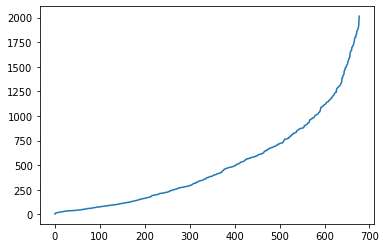

In [25]:
ed_list2 = [e['ed_token_idx'] for i, e in enumerate(ed_token_idx_list) if e['ed_token_idx']<4096]
ed_list2.sort()
plt.plot(ed_list2)
plt.show()

In [27]:
QA_valid_dataset = QA_dataset(QA_valid, tokenizer, 2048)
QA_valid_dataloader = DataLoader(QA_valid_dataset, batch_size=1, shuffle=False)

In [33]:
my_list = []
QA_model.model.eval()
QA_model.model.to(device)
with torch.no_grad():
    for val_batch in tqdm(QA_valid_dataloader):
        target, attention_mask, start, end = val_batch
        target = target.to(device)
        attention_mask = attention_mask.to(device)
        
        outputs = QA_model.model(input_ids = target, attention_mask = attention_mask)
        pred_st = outputs.start_logits.argmax()
        pred_end = outputs.end_logits.argmax() + 1
        pred = target[0][pred_st:pred_end].detach().tolist()
        truth = target[0][start:end].detach().tolist()
        pred_txt = tokenizer.decode(pred)
        truth_txt = tokenizer.decode(truth)
        em = EM(truth, pred)
        f1 = QA_F1(truth, pred)
        my_list.append({'pred_txt':pred_txt,'truth_txt':truth_txt,
                        'em': em ,'f1':f1,
                        'pred':pred,'truth':truth
                       })

100%|██████████| 678/678 [00:17<00:00, 38.15it/s]


In [54]:
QA_valid[26]

{'context': '<h1>재료 및 방법</h1><h2>대상지역과 쌀시료 채취 및 조제</h2><p>본 연구에서는 논토양에서 중(준)금속의 오염이 예상되는 광산 인근 및 공단인근 지역을 배제한 우리나라 지역별 쌀 주산단지로 경기, 강원, 층남, 충북, 전북, 전남, 경북, 경남도별로 각각 12-13 지점에서 2013년 재배한 총 100점을 채취하여 시료로 사용하였다. 수확한 쌀 시료를 풍건한 후, 드라이오븐에서 \\( 60^{\\circ} \\mathrm{C} \\)로 하루 건조 후 현미기(SYTH88, Ssangyong Instrument, Incheon, Korea)를 이용하여 현미로 도정하였고, 실험용 도정기 (McGillmiller, HT McGill Inc, Brookshire, TX, USA)를 이용하여 10분도 백미로 도정하였다. 도정된 현미와 백미는 1분 동안 자동 균질기를 사용하여 고운 가루로 빻아서 실온에 보관하였고 분석시료로 사용하였다.</p><h2>쌀 중 비소함량 분석</h2><p>현미와 백미의 총 비소 함량 분석은 분쇄한 시료 \\( 0.25 \\mathrm{~g} \\) 을 마이크로웨이브(Mars5, CEM, Matthews, NC, USA) 분해용기에 넣고 진한 질산 \\( 8 \\mathrm{~mL} \\) 와 \\( 30 \\% \\) 과산화수소 \\( 1 \\mathrm{~mL} \\) 를 첨가한 후 1시간 정치시켜 발생하는 가스를 제거하고, 모든 vessel은 screwcap으로 밀봉하여 설정된 프로그렘에 의해 microwave digestionsystem (ETHOS, Milestone, Sorisole, Vergamo, Italy)를 이용하여 \\( 180^{\\circ} \\mathrm{C} \\) 에서 20분 동안 분해하여 분해액 중 비소의 함량을 ICP-MS (Agilent 7700, Santa Clara, CA, USA)로 분석하였다. 산 분해 후, vessel용기를 상온에서 층분히 냉각시킨 후 얻은 분해액을 \

In [63]:
QA_valid[26]['context'][1460:1465]

'원심분리기'

In [71]:
a[2], a[3]


(tensor(868), tensor(872))

In [82]:
tokenizer.tokenize('원심분리기를')

['▁원', '심', '분', '리', '기를']

In [69]:
a = QA_valid_dataset[26]
tokenizer.decode(a[0][a[2]:a[3]])

'원심분리'

In [103]:
my_list[45]

{'pred_txt': "Folin & Ciocalteu's phenol 시약",
 'truth_txt': "Folin-Cioaclteu's phenol 시",
 'em': 0,
 'f1': 0.7142857142857143,
 'pred': [30077,
  73,
  619,
  2079,
  29280,
  27805,
  34,
  25,
  7,
  6,
  88322,
  929,
  6452,
  22208],
 'truth': [30077,
  73,
  9,
  441,
  846,
  2263,
  27805,
  34,
  25,
  7,
  6,
  88322,
  929,
  6452]}

In [32]:
my_list[18]

{'pred_txt': '\\(6\\) 회',
 'truth_txt': '\\(6\\) 회 증',
 'em': 0,
 'f1': 0.923076923076923,
 'pred': [6, 41872, 139303, 41872, 16, 59372],
 'truth': [6, 41872, 139303, 41872, 16, 59372, 54447]}

In [88]:
QA_valid_dataset[15][0][1109:1112]

tensor([ 8354, 25354, 12322])

In [92]:
tokenizer.decode(QA_valid_dataset[17][0][1109:1112])

'Korea), 항'

In [79]:
len(tokenizer.tokenize('동결건조'))

4

In [81]:
QA_valid[15]

{'context': '<h2>시료제조</h2><p>시료 제조에 사용된 천마는 천마(GR0)와 증숙 천마로 구분 하였고, 증숙 천마는 \\(1\\)증(GR\\(1\\)), \\(3\\)증(GR\\(3\\)), \\(6\\)증(GR\\(6\\)), \\(9\\)증(GR\\(9\\)) 천마까지 제조하였다.</p><p>천마는 세척 후 일정 크기로 절단하여 건조기에서 건조하였고, 증숙 천마는 \\(1\\)증부터 \\(9\\)증까지 일정한 시간동안 증숙하였고, 증숙 후 건조하여 증숙 횟수를 반복하였다. 증숙은 무압식 스팀증숙기를 사용하여 증숙온도 \\( 90^{\\circ} \\mathrm{C} \\) 에서 \\(2\\)시간씩 물로 증숙하였고, 건조는 밀폐제습식 건조기를 사용하여 수분함량 \\( 15 \\% \\) 미만으로 \\(4\\)시간 동안 건조하였다. 천마의 발효에 사용된 균주는 Lactobacillus plantarum (F\\(1\\)), Leuconostoc mesenteroides (F\\(2\\)), Streptococcus thermophilus (F\\(3\\)), Saccharomyces cerevisiae (F\\(4\\))로 대전대학교 미생명생물공학과 이찬용 교수로부터 받아 사용하였다. 발효 천마의 항산화 활성 및 성분 분석을 위한 시료는 액상발효를 시행하였다. 사각 투명 밀폐용기에 각각 라벨을 붙이고, 시료를 각각 \\( 5 \\mathrm{~g} \\) 씩 넣은 후, \\( 45 \\mathrm{~mL} \\) 의 멸균 증류수를 첨가하여 현탁하였다 \\( (10 \\% \\mathrm{w} / \\mathrm{v}) \\). 시료가 포함된 용기마다 미리 혼합된 복합효소액 \\( 0.5 \\mathrm{~mL} \\) 를 첨가하고 \\(24\\) 시간 반응시켰다. 시료에 따라 정해진 균주 현탁액을 \\( 0.5 \\mathrm{~mL} \\) 씩 접종하여 섭씨 \\( 35^{\\circ} \\mathrm{C} \\) 인큐베이터에서 정치 배양하